# Sequential Convex Programming for Trajectory Generation

### Libraries

In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

import os
import copy
import pickle
import warnings
import numpy as np
from cvxpygen import cpg
import matplotlib.pyplot as plt


from mpc import RUN
from scp import prox_linear
from cvx import parse_convex_problem
from disc import jit_int_mult_fcn, jit_cal_disc_fcn
from jitting import jit_ncvx_dt_fcn_grad, jit_ncvx_ct_fcn_grad

from utils import profile_with_cprofile, make_anim

from model.quad.params import params_fcn, scale_params, unscale_prox_results
from model.quad.dynamics import dynamics
from model.quad.cost_cons import cvx_cost_fcn, cvx_cons_fcn, ncvx_dt_fcn, ncvx_ct_fcn
from model.quad.plot import plot, animation


warnings.filterwarnings("ignore")

### Parameters

In [28]:
t_f = 7.0  # Total simulation time [s]
K = 12 # Total number of nodes
free_final_time = True
time_dil = True

params = params_fcn(t_f, K, free_final_time, time_dil)

params['ite'] = 3000

params['w_con_dyn'] = 100*3
params['w_con_stt'] = 200
params['w_S'] = 0.2/20.0
params['w_ct_fcn'] = [2.0*10]

params['adaptive_step'] = True
params['w_ptr'] = 100
# params['w_ds'] = 5.0
params['w_ds'] = 2.0
# params['w_ds'] = 1.8
# params['w_ds'] = 1.5
# params['w_ds'] = 1.2

params['spd_lim'] = 2.0

params_sc = scale_params(copy.deepcopy(params))
params_sc = dynamics(copy.deepcopy(params_sc))

### Call functions

In [3]:
fcn_dict = {}

fcn_dict['cvx_cost_fcn'] = cvx_cost_fcn
fcn_dict['cvx_cons_fcn'] = cvx_cons_fcn

fcn_dict['cal_disc_jitted'] = jit_cal_disc_fcn(params_sc)
fcn_dict['int_mult_jitted'] = jit_int_mult_fcn(params_sc)

fcn_dict['ncvx_dt_fcn_jitted'], fcn_dict['ncvx_dt_fcn_grad_jitted'] = jit_ncvx_dt_fcn_grad(ncvx_dt_fcn, params_sc)
fcn_dict['ncvx_ct_fcn_jitted'], fcn_dict['ncvx_ct_fcn_grad_jitted'] = jit_ncvx_ct_fcn_grad(ncvx_ct_fcn, params_sc)

### Code generation

In [29]:
if not(params['use_generated_code']) or params['generate_code']:
    # Parse problem if you are not using the generated code
    cvx_prb = parse_convex_problem(params_sc, fcn_dict)

In [30]:
if params['generate_code']:
    # Generate code
    code_dir = "solver"
    !rm -rf solver/*
    os.makedirs(code_dir, exist_ok=True)  # <- This ensures the directory exists
    cpg.generate_code(cvx_prb, solver = params['convex_solver'], wrapper = True, code_dir=code_dir)

In [31]:
if params['use_generated_code']:
    # Use generated code
    with open('solver/problem.pickle', 'rb') as f:
        cvx_prb = pickle.load(f)      

    from solver.cpg_solver import cpg_solve
    cvx_prb.register_solve('CPG', cpg_solve)

### Prox-linear

In [32]:
prev_sol = False
if prev_sol:
    params_sc['ite'] = 500
    params_sc['w_ptr'] = 800

    params_sc['X_last'] = prox_results_sc['X_new']
    params_sc['U_last'] = prox_results_sc['U_new']
    params_sc['S_last'] = prox_results_sc['S_new']

prox_results_sc = prox_linear(  copy.deepcopy(params_sc), 
                                cvx_prb,
                                fcn_dict,
                                )

# prox_results_sc = profile_with_cprofile(scp.prox_linear, 
#                                         copy.deepcopy(params_sc), 
#                                         cvx_prb,
#                                         fcn_dict
#                                         )

Ite              T-Ite            T-Disc           T-SubP           T-J_Np           S_cost           dyn_cost         state_cost       none             until_pos_spd    ptr_cost         lcd              nlcd             lc               nlc              D-NL             D-L              Rho              W-TR             Note             Staus            
0                0                0                0                0                0.01             1200.0           0.0              0.0              11.5663          0.0              0.0              1200.0           0.0              1211.5763        0                0                0                100              Start            Start            
1                0.0629           0.0007           0.0098           0.0451           0.01             312.3398         0.0              0.0              26.6611          252.9478         293.9137         312.3398         306.4901         339.0109         872.5654         905.0862    

In [33]:
print('Total iteration      time:', round(sum(prox_results_sc['T-Ite']), 3))
print('Total discretization time:', round(sum(prox_results_sc['T-Disc']), 3))
print('Total subproblem     time:', round(sum(prox_results_sc['T-SubP']), 3))
print('Total Jax to Numpy   time:', round(sum(prox_results_sc['T-J_Np']), 3))

print('\n')

tot_dsj = sum(prox_results_sc['T-Disc']) + sum(prox_results_sc['T-SubP']) + sum(prox_results_sc['T-J_Np'])
print('Total disc-subp-j_np time:', round(tot_dsj, 3))
print('Total others         time:', round(sum(prox_results_sc['T-Ite']) - tot_dsj, 3))

print('\n')

print('Flight time:', round(prox_results_sc['S_new'].sum(), 3))

Total iteration      time: 4.174
Total discretization time: 0.009
Total subproblem     time: 1.024
Total Jax to Numpy   time: 2.699


Total disc-subp-j_np time: 3.732
Total others         time: 0.442


Flight time: 20.854


### Dump results

In [34]:
# with open('prox_results_sc.pickle', 'wb') as out_f:
#     out_f.write(pickle.dumps(prox_results_sc))

In [35]:
# with open('prox_results_sc.pickle', 'rb') as f:
#     prox_results_sc = pickle.load(f)      

In [36]:
# with open('results.pickle', 'wb') as out_f:
#     out_f.write(pickle.dumps(results))
    
# with open('params.pickle', 'wb') as out_f:
#     out_f.write(pickle.dumps(params))

### Simulate

In [37]:
prox_results = unscale_prox_results(copy.deepcopy(prox_results_sc), params)

params = dynamics(copy.deepcopy(params))

results = RUN(copy.deepcopy(prox_results), 
                 copy.deepcopy(params))

In [38]:
# results_2 = np.ones(100)*10
# results_min = results_2.min()
# izi = 0
# # for i in range(params['rk4_steps_dyn']-3,params['rk4_steps_dyn']+3,1):
# for i in range(99,102,1):
#     params['N_dt'] = i

#     results_cnd = RUN(copy.deepcopy(prox_results), 
#                       copy.deepcopy(params))


#     aka = np.min(np.linalg.norm(results_cnd['x_all'][:, 0:3] - params['p_w'][None, 0:3], axis=1))
#     results_2[izi] = aka
#     izi += 1
#     print(i, aka, results_2.min())

#     if aka < results_min:
#         results = copy.deepcopy(results_cnd)
#         results_min = results_2.min()

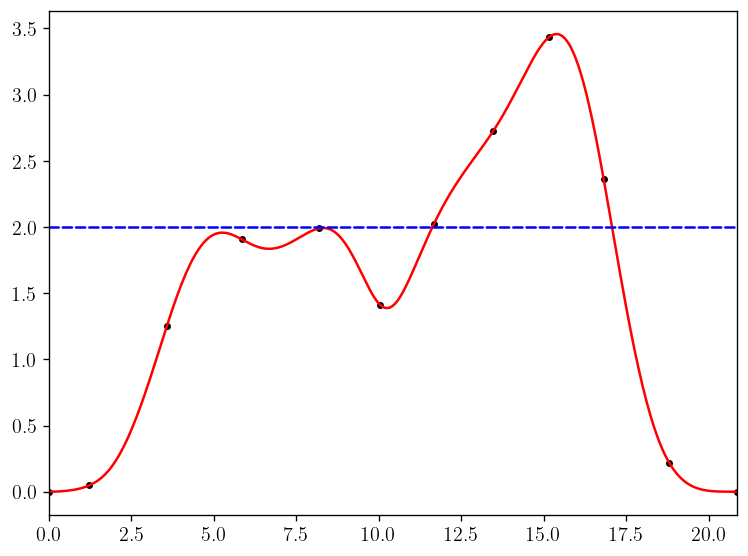

In [39]:
# Create figure and axis
fig, ax = plt.subplots()

# Continuous speed norm over time
speed_norm = np.linalg.norm(results['x_all'][:, 3:6], axis=1)
ax.plot(results['times_all'], speed_norm, color='red', label='Interpolated')
# ax.scatter(results['times_all'], speed_norm, s=5, color='blue')

# Node-based speed values
speed_nodes = np.linalg.norm(results['x_nmpc_all'][0, :, 3:6], axis=1)
ax.scatter(results['times_nodes'], speed_nodes, s=10, color='black', label='Nodes')

# Dashed speed limit line
# ax.axhline(y=params['vehicle_v_max'], color='blue', linestyle='dashed', label=r'$v_{max}$')
ax.axhline(y=params['spd_lim'], color='blue', linestyle='dashed', label=r'$v_{max}$')

# Labels and aesthetics
# ax.set_xlabel(r'Time [s]', fontsize=xy_fs)
# ax.set_ylabel(r'Speed, $v$ [m/s]', fontsize=xy_fs)
# ax.legend(fontsize=legend_fs)
# ax.grid(True)

# Optional: tighten layout
plt.tight_layout()
plt.show()

np.float64(0.017403515710421147)

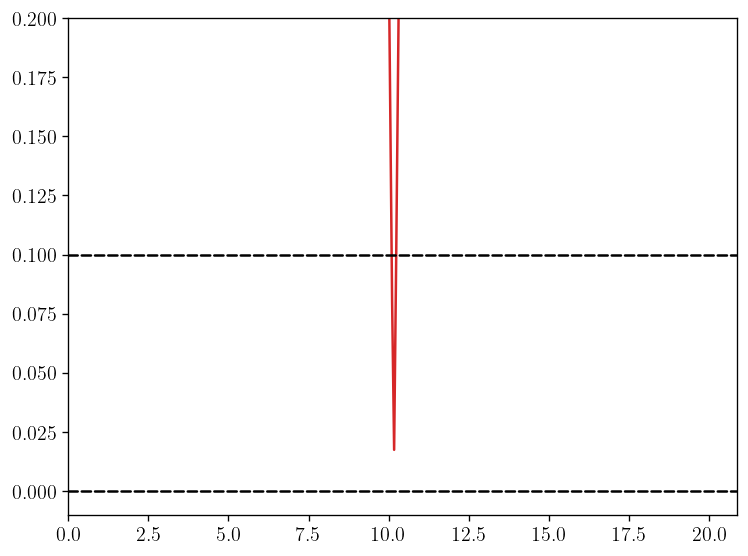

In [40]:
plt.plot(results['times_all'], np.linalg.norm(results['x_all'][:, 0:3] - params['p_w'][None, 0:3], axis=1))
# plt.ylim(-1e-4, 1.1)
# plt.ylim(-1e-4, 0.3)
# plt.ylim(-1e-4, 0.1)
# plt.ylim(-1e-4, 0.01)
# plt.ylim(-1e-4, 0.001)
# plt.ylim(-1e-4, 0.002)
# plt.ylim(-1e-4, 0.004)
plt.ylim(-1e-2, params['r_w']+0.1)


# plt.ylim(-1e-4, 0.01)
# plt.ylim(-1e-4, 0.1)
plt.axhline(y=params['r_w'], c='black', ls='dashed')
plt.axhline(y=0, c='black', ls='dashed')
np.min(np.linalg.norm(results['x_all'][:, 0:3] - params['p_w'][None, 0:3], axis=1))

### Plot results

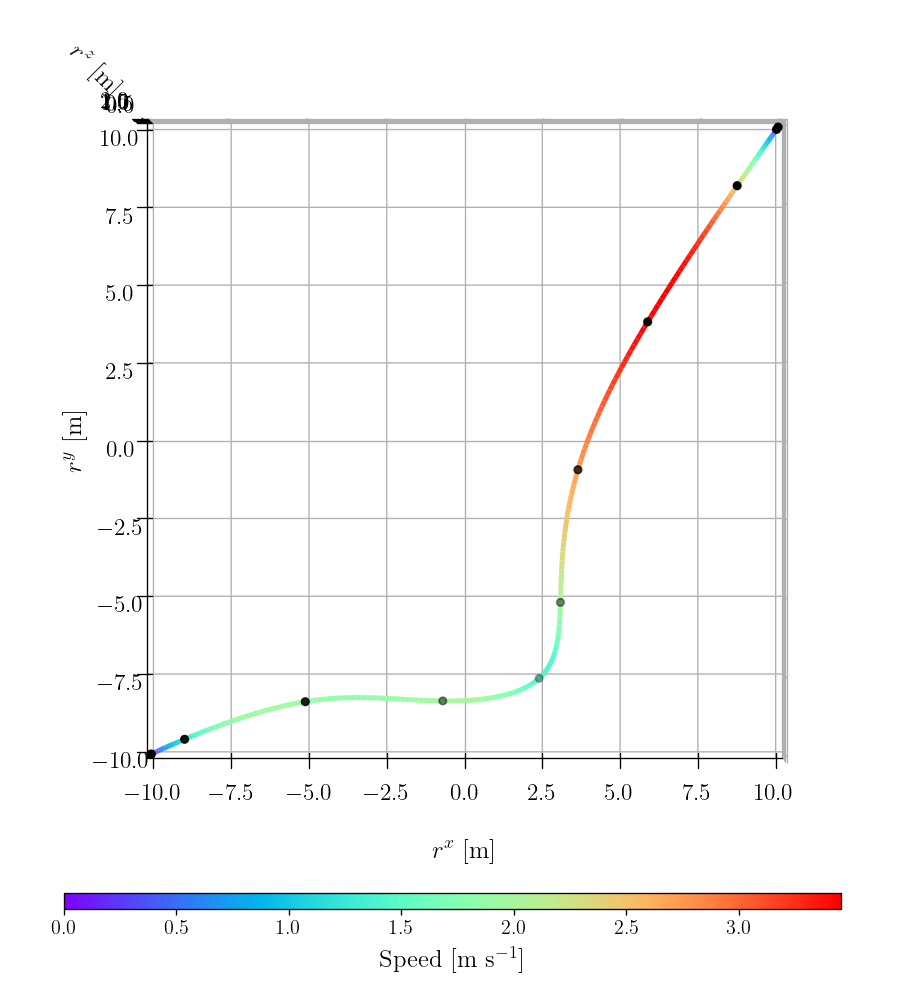

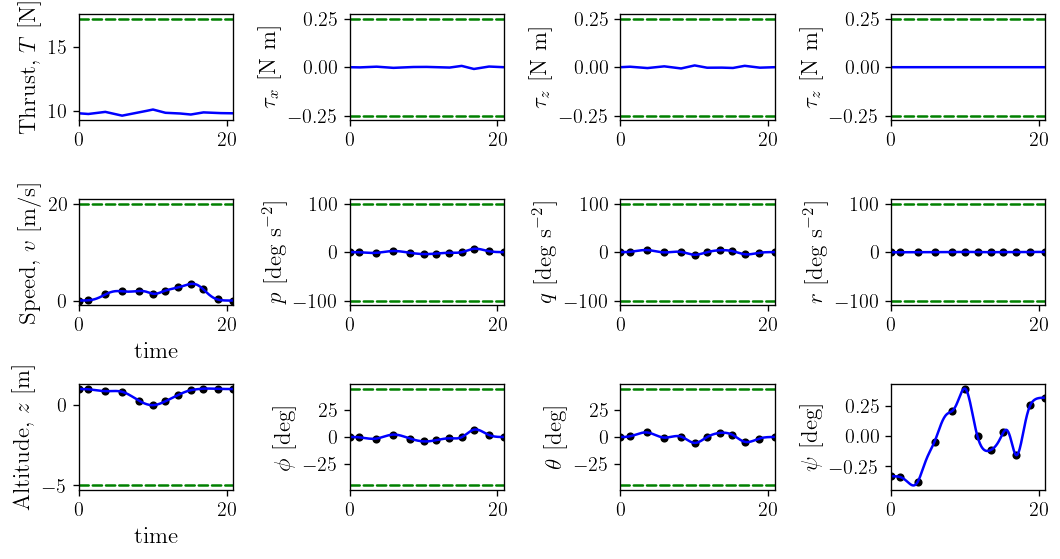

In [41]:
plot(results, params)

### Animation

In [42]:
save_anim = False
if save_anim:
    animation(results, params, delt=2)
    make_anim(load_from = 'sim/', 
              save_to = 'quad_flight',
              duration = 5.0, 
              fps = 24, 
              anim_format = 'gif')
    
